In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.metric.metric import Metric
from financial_common.risk.risk_type import RiskType
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
ori = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("cryptocurrencies")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("crypto",{"ticker":"BTC-USD"})
benchmark = p.utc_date(benchmark)
benchmark["close"] = benchmark["close"].astype(float)
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"close")

In [35]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("crypto", {"ticker": ticker})
        for col in price.columns:
            if col not in ["date", "ticker"]:
                try:
                    price[col] = price[col].astype(float)
                    price.rename(columns={col:"adj"+col},inplace=True)
                except Exception as e:
                    print(str(e))
                    continue
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=30)
            for member in Indicator:
                price = member.calculate(price,timeframe=30)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.38it/s]


In [36]:
model_end = 2023
backtest_end = 2026
simulation = pd.concat(prices)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['adjstart', 'adjlow', 'adjhigh', 'adjopen', 'adjclose', 'adjvolume',
       'ticker', 'date', 'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low', 'average_return',
       'standard_dev', 'rolling_dollar_volume', 'simple_moving_average', 'adr',
       'sma', 'sma_corr', 'ema', 'ema_corr', 'ema_volume_corr',
       'bollinger_upper', 'bollinger_lower', 'momentum', 'roc', 'williams_r',
       'obv', 'vwap', 'market_impact', 'atr', 'coefficient_of_variation'],
      dtype='object')

In [37]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[1])

In [38]:
additional_portfolios = []

for portfolio in portfolios:
    if portfolio.timeframe.value == "week":
        for member in Indicator:
            portfolio_copy = copy.deepcopy(portfolio)
            portfolio_copy.ranking_metric = member.label
            additional_portfolios.append(portfolio_copy)


In [39]:
analysises = []
for portfolio in tqdm(additional_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [00:14<00:00, 32.57it/s]


In [40]:
a = pd.DataFrame(analysises)
a.columns

Index(['ranking_metric', 'timeframe', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'date', 'pnl', 'coefficient_of_variation',
       'portfolio_std', 'average_gain', 'average_loss', 'win_loss_ratio',
       'weekly_return', 'sharpe_ratio', 'portfolio'],
      dtype='object')

In [41]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
479,1.294468,vwap,WEEK,long,ROLLING_DOLLAR_VOLUME,long_short,equal,coefficient_of_variation,1,11.575401,0.111829,1.081103,0.916558,0.539889,1.005394,-1.912715,<financial_common.portfolio_management.portfol...
478,1.245926,vwap,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,1,13.807712,0.090234,1.082152,0.914727,0.537106,1.004652,-2.908429,<financial_common.portfolio_management.portfol...
477,1.216813,ema_corr,WEEK,long,ROLLING_DOLLAR_VOLUME,long_short,equal,coefficient_of_variation,1,21.652212,0.056198,1.086361,0.914531,0.521336,1.004112,-5.187939,<financial_common.portfolio_management.portfol...
476,1.208205,vwap,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,1,5.156269,0.234318,1.085859,0.929142,0.499072,1.007355,-1.280996,<financial_common.portfolio_management.portfol...
475,1.190470,momentum,WEEK,long,SIMPLE_MOVING_AVERAGE,long_short,equal,coefficient_of_variation,1,13.422385,0.088693,1.087680,0.917778,0.505566,1.003674,-3.584224,<financial_common.portfolio_management.portfol...
474,1.188315,ema,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,1,18.420914,0.064509,1.089169,0.914087,0.512059,1.003739,-4.961320,<financial_common.portfolio_management.portfol...
473,1.179832,atr,WEEK,long,ROLLING_DOLLAR_VOLUME,long_short,equal,coefficient_of_variation,1,16.345123,0.072182,1.077297,0.918471,0.535250,1.003482,-4.551428,<financial_common.portfolio_management.portfol...
472,1.167509,market_impact,WEEK,long,AVERAGE_RETURN,long_short,equal,coefficient_of_variation,1,15.870234,0.073566,1.088787,0.915954,0.505566,1.003333,-4.633341,<financial_common.portfolio_management.portfol...
471,1.166207,williams_r,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,1,13.690645,0.085183,1.083359,0.917061,0.518553,1.003295,-4.016753,<financial_common.portfolio_management.portfol...
470,1.163227,adr,WEEK,short,STANDARD_DEV,long_short,equal,coefficient_of_variation,1,14.489629,0.080280,1.081614,0.914718,0.530612,1.003275,-4.299189,<financial_common.portfolio_management.portfol...


In [42]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

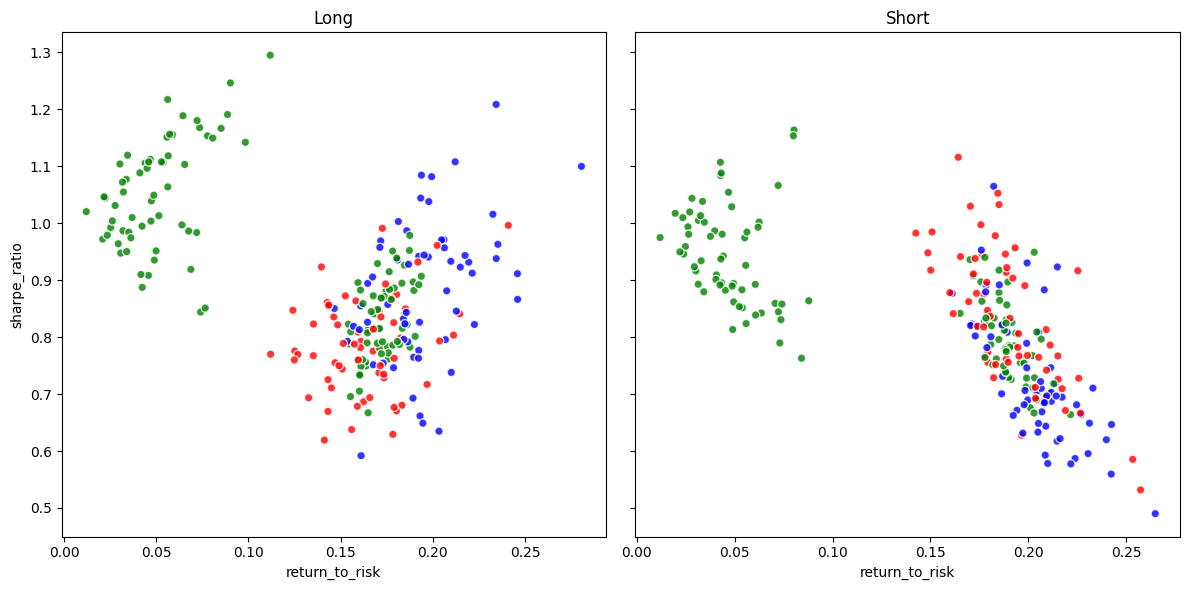

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [44]:
top = a[a["timeframe"]=="WEEK"].sort_values("pnl",ascending=False).to_dict("records")[0]
top

{'ranking_metric': 'vwap',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'ROLLING_DOLLAR_VOLUME',
 'selection_type': 'long_short',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 1,
 'date': Timestamp('2025-05-15 00:00:00+0000', tz='UTC'),
 'pnl': 1.2944677919887866,
 'coefficient_of_variation': 11.575401361271249,
 'portfolio_std': 0.11182919292282958,
 'average_gain': 1.0811031126069146,
 'average_loss': 0.9165580772907476,
 'win_loss_ratio': 0.5398886827458256,
 'weekly_return': 1.0053940796599583,
 'sharpe_ratio': -1.912715235993983,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1ca2dbd6810>,
 'color': 'green',
 'return_to_risk': 11.575401361271249}

In [45]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","industry"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

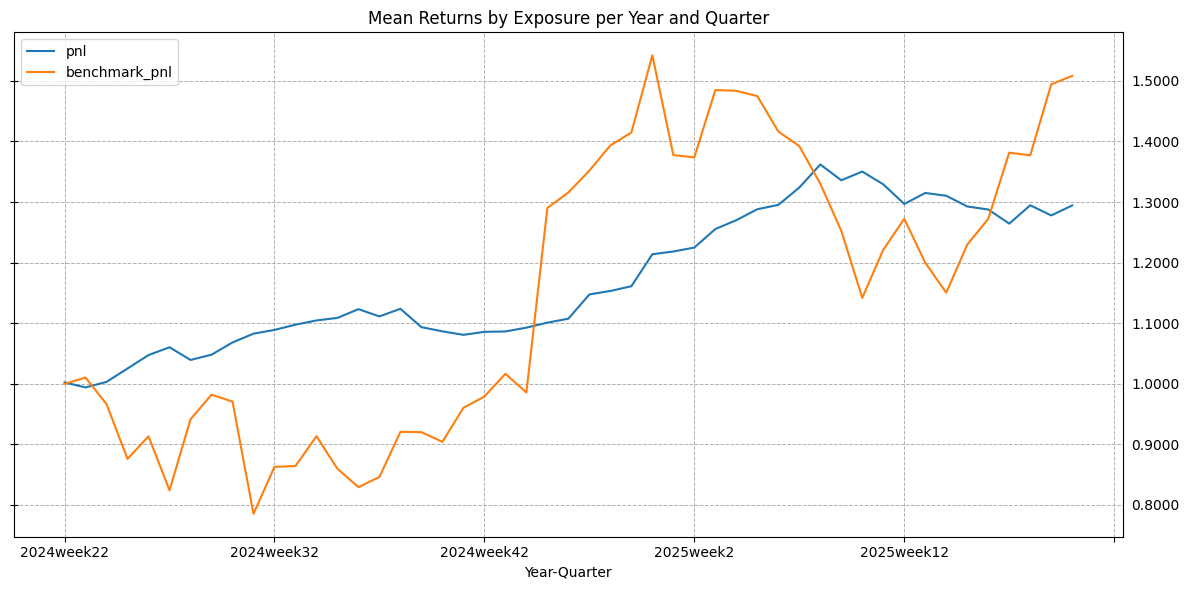

In [46]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + pm.timeframe.value + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [47]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
FET-USD,1.092362
IMX-USD,1.063978
EOS-USD,1.049274
ATOM-USD,1.043488
LINK-USD,1.042444
FLOKI-USD,1.036496
ICP-USD,1.034316
ADA-USD,1.032550
ARB-USD,1.031686


In [48]:
ori.cloud_connect()
ori.drop("crypto_results")
ori.store("crypto_results",pd.DataFrame([top]).drop("portfolio",axis=1))
ori.disconnect()